# Session 2: The Market Model and Normal Return Estimation

## Event Studies in Finance and Economics - Summer School

---

### Learning Objectives

By the end of this session, you will be able to:

1. Explain the theoretical foundations of different normal return models
2. Implement and compare multiple benchmark models (constant mean, market model, CAPM, Fama-French)
3. Understand the statistical properties of OLS estimation in the event study context
4. Diagnose and address common estimation issues
5. Make informed choices about model selection for your research

---

## 1. Introduction: Why Normal Returns Matter

Recall from Session 1 that the abnormal return is defined as:

$$AR_{i,t} = R_{i,t} - E[R_{i,t} | X_t]$$

The **entire validity** of an event study hinges on correctly specifying $E[R_{i,t} | X_t]$ — the "normal" or expected return. If our model of normal returns is misspecified, our abnormal returns will be biased.

### The Challenge

We face a fundamental identification problem: we never observe the counterfactual — what the return *would have been* absent the event. Instead, we must model it based on historical relationships and economic theory.

## 2. Taxonomy of Normal Return Models

### Statistical Models

| Model | Specification | Key Assumption |
|-------|--------------|----------------|
| **Constant Mean** | $E[R_{i,t}] = \mu_i$ | Returns are i.i.d. with constant mean |
| **Market Model** | $E[R_{i,t}] = \alpha_i + \beta_i R_{m,t}$ | Linear relationship with market |
| **Market-Adjusted** | $E[R_{i,t}] = R_{m,t}$ | Stock moves 1:1 with market |

### Economic Models

| Model | Specification | Theoretical Basis |
|-------|--------------|-------------------|
| **CAPM** | $E[R_{i,t}] = R_f + \beta_i(R_{m,t} - R_f)$ | Mean-variance optimization |
| **Fama-French 3-Factor** | $E[R_{i,t}] = \alpha + \beta^{MKT}MKT + \beta^{SMB}SMB + \beta^{HML}HML$ | Empirical regularities |
| **Carhart 4-Factor** | Fama-French + Momentum factor | Price momentum anomaly |

## 3. Setup and Data Acquisition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yfinance as yf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Event Study Configuration
TICKER = 'MSFT'
EVENT_DATE = '2023-01-24'  # Q2 FY2023 Earnings
ESTIMATION_WINDOW = 252
GAP = 10
EVENT_WINDOW_PRE = 5
EVENT_WINDOW_POST = 5

print(f"Event Study: {TICKER} Earnings Announcement")
print(f"Event Date: {EVENT_DATE}")

Event Study: MSFT Earnings Announcement
Event Date: 2023-01-24


In [5]:
def download_stock_and_factors(ticker, event_date, est_window, gap, pre, post):
    """Download stock data and factor proxies for event study."""
    event_dt = pd.to_datetime(event_date)
    start_date = event_dt - timedelta(days=int((est_window + gap + pre) * 1.5))
    end_date = event_dt + timedelta(days=int(post * 2.5))
    
    stock = yf.download(ticker, start=start_date, end=end_date, progress=False)['Close']
    market = yf.download('^GSPC', start=start_date, end=end_date, progress=False)['Close']
    
    try:
        rf_data = yf.download('^IRX', start=start_date, end=end_date, progress=False)['Close']
        rf_daily = (rf_data / 100) / 252
    except:
        rf_daily = pd.Series(0, index=stock.index)
    
    etfs = yf.download(['SPY', 'IWM', 'IWD', 'IWF', 'MTUM'], 
                       start=start_date, end=end_date, progress=False)['Close']
    
    df = pd.DataFrame({'stock_price': stock.squeeze(), 'market_price': market.squeeze()})
    for etf in ['SPY', 'IWM', 'IWD', 'IWF', 'MTUM']:
        if etf in etfs.columns:
            df[f'{etf}_price'] = etfs[etf]
    
    df['stock_ret'] = df['stock_price'].pct_change()
    df['market_ret'] = df['market_price'].pct_change()
    df['rf'] = rf_daily.reindex(df.index).fillna(method='ffill').fillna(0)
    df['stock_excess'] = df['stock_ret'] - df['rf']
    df['market_excess'] = df['market_ret'] - df['rf']
    
    if 'SPY_price' in df.columns and 'IWM_price' in df.columns:
        df['SMB'] = df['IWM_price'].pct_change() - df['SPY_price'].pct_change()
    if 'IWD_price' in df.columns and 'IWF_price' in df.columns:
        df['HML'] = df['IWD_price'].pct_change() - df['IWF_price'].pct_change()
    if 'MTUM_price' in df.columns:
        df['MOM'] = df['MTUM_price'].pct_change() - df['market_ret']
    
    df = df.dropna()
    
    if event_dt not in df.index:
        idx = df.index.get_indexer([event_dt], method='nearest')[0]
        event_dt = df.index[idx]
        print(f"Event date adjusted to: {event_dt.date()}")
    
    event_idx = df.index.get_loc(event_dt)
    df['event_time'] = range(-event_idx, len(df) - event_idx)
    
    return df, event_dt

data, actual_event_date = download_stock_and_factors(
    TICKER, EVENT_DATE, ESTIMATION_WINDOW, GAP, EVENT_WINDOW_PRE, EVENT_WINDOW_POST
)
print(f"Data downloaded: {len(data)} trading days")

YF.download() has changed argument auto_adjust default to True
Data downloaded: 282 trading days


In [7]:
def split_windows(df, est_window, gap, pre, post):
    """Split data into estimation and event windows."""
    est_end = -(gap + pre)
    est_start = est_end - est_window
    
    estimation = df[(df['event_time'] >= est_start) & (df['event_time'] < est_end)].copy()
    event = df[(df['event_time'] >= -pre) & (df['event_time'] <= post)].copy()
    
    print(f"Estimation window: {len(estimation)} days ({estimation.index[0].date()} to {estimation.index[-1].date()})")
    print(f"Event window: {len(event)} days ({event.index[0].date()} to {event.index[-1].date()})")
    return estimation, event

estimation_data, event_data = split_windows(data, ESTIMATION_WINDOW, GAP, EVENT_WINDOW_PRE, EVENT_WINDOW_POST)

Estimation window: 252 days (2021-12-30 to 2022-12-29)
Event window: 11 days (2023-01-17 to 2023-01-31)


## 4. Model 1: Constant Mean Return Model

$$R_{i,t} = \mu_i + \epsilon_{i,t}$$

The simplest model: expected return equals the historical mean.

In [9]:
class ConstantMeanModel:
    def __init__(self):
        self.name = "Constant Mean"
        self.mu = None
        self.sigma = None
        self.n_obs = None
        self.ols_results = None
        
    def fit(self, returns):
        returns = np.asarray(returns)
        self.n_obs = len(returns)
        self.mu = np.mean(returns)
        self.residuals = returns - self.mu
        self.sigma = np.std(self.residuals, ddof=1)
        self.r_squared = 0.0
        return self
    
    def predict(self, X=None):
        if X is None:
            return self.mu
        return np.full(len(X) if hasattr(X, '__len__') else 1, self.mu)
    
    def summary(self):
        print(f"\n{'='*50}")
        print(f"Model: {self.name}")
        print(f"{'='*50}")
        print(f"Observations: {self.n_obs}")
        print(f"Mean Return: {self.mu:.6f} ({self.mu*100:.4f}%)")
        print(f"Std. Deviation: {self.sigma:.6f}")
        print(f"Annualized Return: {self.mu*252*100:.2f}%")
        print(f"Annualized Volatility: {self.sigma*np.sqrt(252)*100:.2f}%")

const_model = ConstantMeanModel()
const_model.fit(estimation_data['stock_ret'])
const_model.summary()


Model: Constant Mean
Observations: 252
Mean Return: -0.001105 (-0.1105%)
Std. Deviation: 0.022209
Annualized Return: -27.84%
Annualized Volatility: 35.26%


## 5. Model 2: Market Model

$$R_{i,t} = \alpha_i + \beta_i R_{m,t} + \epsilon_{i,t}$$

The workhorse of event studies.

In [11]:
class MarketModel:
    def __init__(self):
        self.name = "Market Model"
        self.alpha = None
        self.beta = None
        self.sigma = None
        self.r_squared = None
        self.n_obs = None
        self.ols_results = None
        
    def fit(self, stock_returns, market_returns):
        y = np.asarray(stock_returns)
        x = np.asarray(market_returns)
        self.n_obs = len(y)
        self.market_mean = np.mean(x)
        self.market_var = np.sum((x - self.market_mean)**2)
        
        X = sm.add_constant(x)
        self.ols_results = sm.OLS(y, X).fit()
        
        self.alpha = self.ols_results.params[0]
        self.beta = self.ols_results.params[1]
        self.residuals = self.ols_results.resid
        self.sigma = np.std(self.residuals, ddof=2)
        self.r_squared = self.ols_results.rsquared
        return self
    
    def predict(self, market_returns):
        return self.alpha + self.beta * np.asarray(market_returns)
    
    def summary(self):
        print(f"\n{'='*50}")
        print(f"Model: {self.name}")
        print(f"{'='*50}")
        print(f"Observations: {self.n_obs}")
        print(f"\nCoefficients:")
        print(f"  alpha: {self.alpha:.6f} (t={self.ols_results.tvalues[0]:.2f})")
        print(f"  beta:  {self.beta:.4f} (t={self.ols_results.tvalues[1]:.2f})")
        print(f"\nModel Fit:")
        print(f"  R-squared: {self.r_squared:.4f}")
        print(f"  Residual sigma: {self.sigma:.6f}")

market_model = MarketModel()
market_model.fit(estimation_data['stock_ret'], estimation_data['market_ret'])
market_model.summary()


Model: Market Model
Observations: 252

Coefficients:
  alpha: -0.000136 (t=-0.20)
  beta:  1.2832 (t=29.02)

Model Fit:
  R-squared: 0.7711
  Residual sigma: 0.010647


In [13]:
print("\nDetailed OLS Results:")
print(market_model.ols_results.summary())


Detailed OLS Results:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     842.1
Date:                Fri, 23 Jan 2026   Prob (F-statistic):           5.23e-82
Time:                        10:44:15   Log-Likelihood:                 788.13
No. Observations:                 252   AIC:                            -1572.
Df Residuals:                     250   BIC:                            -1565.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.

## 6. Model 3: CAPM

$$R_{i,t} - R_{f,t} = \alpha_i + \beta_i (R_{m,t} - R_{f,t}) + \epsilon_{i,t}$$

In [15]:
class CAPMModel:
    def __init__(self):
        self.name = "CAPM"
        self.alpha = None
        self.beta = None
        self.sigma = None
        self.r_squared = None
        self.n_obs = None
        self.ols_results = None
        
    def fit(self, stock_excess, market_excess):
        y = np.asarray(stock_excess)
        x = np.asarray(market_excess)
        self.n_obs = len(y)
        
        X = sm.add_constant(x)
        self.ols_results = sm.OLS(y, X).fit()
        
        self.alpha = self.ols_results.params[0]
        self.beta = self.ols_results.params[1]
        self.residuals = self.ols_results.resid
        self.sigma = np.std(self.residuals, ddof=2)
        self.r_squared = self.ols_results.rsquared
        return self
    
    def predict(self, market_excess):
        return self.alpha + self.beta * np.asarray(market_excess)
    
    def predict_return(self, market_ret, rf):
        market_excess = np.asarray(market_ret) - np.asarray(rf)
        return self.predict(market_excess) + np.asarray(rf)
    
    def summary(self):
        print(f"\n{'='*50}")
        print(f"Model: {self.name}")
        print(f"{'='*50}")
        print(f"Observations: {self.n_obs}")
        print(f"  alpha (Jensen's): {self.alpha:.6f} (t={self.ols_results.tvalues[0]:.2f})")
        print(f"  beta: {self.beta:.4f} (t={self.ols_results.tvalues[1]:.2f})")
        print(f"  R-squared: {self.r_squared:.4f}")

capm_model = CAPMModel()
capm_model.fit(estimation_data['stock_excess'], estimation_data['market_excess'])
capm_model.summary()


Model: CAPM
Observations: 252
  alpha (Jensen's): -0.000114 (t=-0.17)
  beta: 1.2832 (t=29.02)
  R-squared: 0.7710


## 7. Model 4: Fama-French Three-Factor Model

$$R_{i,t} - R_{f,t} = \alpha + \beta^{MKT}MKT_t + \beta^{SMB}SMB_t + \beta^{HML}HML_t + \epsilon_{i,t}$$

In [17]:
class FamaFrench3Model:
    def __init__(self):
        self.name = "Fama-French 3-Factor"
        self.alpha = None
        self.beta_mkt = None
        self.beta_smb = None
        self.beta_hml = None
        self.sigma = None
        self.r_squared = None
        self.adj_r_squared = None
        self.n_obs = None
        self.ols_results = None
        
    def fit(self, stock_excess, market_excess, smb, hml):
        y = np.asarray(stock_excess)
        X = np.column_stack([np.ones(len(y)), market_excess, smb, hml])
        self.n_obs = len(y)
        self.ols_results = sm.OLS(y, X).fit()
        
        self.alpha = self.ols_results.params[0]
        self.beta_mkt = self.ols_results.params[1]
        self.beta_smb = self.ols_results.params[2]
        self.beta_hml = self.ols_results.params[3]
        self.residuals = self.ols_results.resid
        self.sigma = np.std(self.residuals, ddof=4)
        self.r_squared = self.ols_results.rsquared
        self.adj_r_squared = self.ols_results.rsquared_adj
        return self
    
    def predict(self, market_excess, smb, hml):
        return (self.alpha + self.beta_mkt * np.asarray(market_excess) +
                self.beta_smb * np.asarray(smb) + self.beta_hml * np.asarray(hml))
    
    def predict_return(self, market_ret, rf, smb, hml):
        market_excess = np.asarray(market_ret) - np.asarray(rf)
        return self.predict(market_excess, smb, hml) + np.asarray(rf)
    
    def summary(self):
        print(f"\n{'='*60}")
        print(f"Model: {self.name}")
        print(f"{'='*60}")
        print(f"Observations: {self.n_obs}")
        print(f"  alpha: {self.alpha:.6f} (t={self.ols_results.tvalues[0]:.2f})")
        print(f"  beta_MKT: {self.beta_mkt:.4f} (t={self.ols_results.tvalues[1]:.2f})")
        print(f"  beta_SMB: {self.beta_smb:.4f} (t={self.ols_results.tvalues[2]:.2f})")
        print(f"  beta_HML: {self.beta_hml:.4f} (t={self.ols_results.tvalues[3]:.2f})")
        print(f"  R-squared: {self.r_squared:.4f}, Adj R-squared: {self.adj_r_squared:.4f}")

if 'SMB' in estimation_data.columns and 'HML' in estimation_data.columns:
    ff3_model = FamaFrench3Model()
    ff3_model.fit(estimation_data['stock_excess'], estimation_data['market_excess'],
                  estimation_data['SMB'], estimation_data['HML'])
    ff3_model.summary()
else:
    ff3_model = None
    print("Factor data not available")


Model: Fama-French 3-Factor
Observations: 252
  alpha: 0.000360 (t=0.67)
  beta_MKT: 1.0117 (t=21.28)
  beta_SMB: -0.5535 (t=-6.58)
  beta_HML: -0.7467 (t=-10.18)
  R-squared: 0.8556, Adj R-squared: 0.8538


## 8. Model 5: Carhart Four-Factor Model

Adds momentum to Fama-French.

In [19]:
class Carhart4Model:
    def __init__(self):
        self.name = "Carhart 4-Factor"
        self.alpha = None
        self.beta_mkt = None
        self.beta_smb = None
        self.beta_hml = None
        self.beta_mom = None
        self.sigma = None
        self.r_squared = None
        self.adj_r_squared = None
        self.n_obs = None
        self.ols_results = None
        
    def fit(self, stock_excess, market_excess, smb, hml, mom):
        y = np.asarray(stock_excess)
        X = np.column_stack([np.ones(len(y)), market_excess, smb, hml, mom])
        self.n_obs = len(y)
        self.ols_results = sm.OLS(y, X).fit()
        
        self.alpha = self.ols_results.params[0]
        self.beta_mkt = self.ols_results.params[1]
        self.beta_smb = self.ols_results.params[2]
        self.beta_hml = self.ols_results.params[3]
        self.beta_mom = self.ols_results.params[4]
        self.residuals = self.ols_results.resid
        self.sigma = np.std(self.residuals, ddof=5)
        self.r_squared = self.ols_results.rsquared
        self.adj_r_squared = self.ols_results.rsquared_adj
        return self
    
    def predict(self, market_excess, smb, hml, mom):
        return (self.alpha + self.beta_mkt * np.asarray(market_excess) +
                self.beta_smb * np.asarray(smb) + self.beta_hml * np.asarray(hml) +
                self.beta_mom * np.asarray(mom))
    
    def summary(self):
        print(f"\n{'='*60}")
        print(f"Model: {self.name}")
        print(f"{'='*60}")
        print(f"Observations: {self.n_obs}")
        print(f"  alpha: {self.alpha:.6f} (t={self.ols_results.tvalues[0]:.2f})")
        print(f"  beta_MKT: {self.beta_mkt:.4f} (t={self.ols_results.tvalues[1]:.2f})")
        print(f"  beta_SMB: {self.beta_smb:.4f} (t={self.ols_results.tvalues[2]:.2f})")
        print(f"  beta_HML: {self.beta_hml:.4f} (t={self.ols_results.tvalues[3]:.2f})")
        print(f"  beta_MOM: {self.beta_mom:.4f} (t={self.ols_results.tvalues[4]:.2f})")
        print(f"  R-squared: {self.r_squared:.4f}")

if all(col in estimation_data.columns for col in ['SMB', 'HML', 'MOM']):
    carhart_model = Carhart4Model()
    carhart_model.fit(estimation_data['stock_excess'], estimation_data['market_excess'],
                      estimation_data['SMB'], estimation_data['HML'], estimation_data['MOM'])
    carhart_model.summary()
else:
    carhart_model = None
    print("Momentum factor not available")


Model: Carhart 4-Factor
Observations: 252
  alpha: 0.000370 (t=0.70)
  beta_MKT: 0.9885 (t=20.54)
  beta_SMB: -0.5264 (t=-6.26)
  beta_HML: -0.7662 (t=-10.47)
  beta_MOM: -0.1847 (t=-2.35)
  R-squared: 0.8587


## 9. Model Comparison

In [21]:
all_models = {
    'Constant Mean': const_model,
    'Market Model': market_model,
    'CAPM': capm_model,
    'Fama-French 3': ff3_model,
    'Carhart 4': carhart_model
}

results = []
for name, model in all_models.items():
    if model is None:
        continue
    r2 = model.r_squared if hasattr(model, 'r_squared') else 0.0
    adj_r2 = model.adj_r_squared if hasattr(model, 'adj_r_squared') else r2
    k = len(model.ols_results.params) if hasattr(model, 'ols_results') and model.ols_results else 1
    sse = np.sum(model.residuals**2)
    n = model.n_obs
    aic = n * np.log(sse/n) + 2*k
    bic = n * np.log(sse/n) + k*np.log(n)
    results.append({'Model': name, 'R2': r2, 'Adj_R2': adj_r2, 'Sigma': model.sigma, 'AIC': aic, 'BIC': bic})

comparison = pd.DataFrame(results)
print("\nModel Comparison:")
print(comparison.to_string(index=False))


Model Comparison:
        Model       R2   Adj_R2    Sigma          AIC          BIC
Constant Mean 0.000000 0.000000 0.022209 -1917.861341 -1914.331912
 Market Model 0.771081 0.771081 0.010647 -2287.406507 -2280.347649
         CAPM 0.771036 0.771036 0.010647 -2287.409194 -2280.350336
Fama-French 3 0.855563 0.853816 0.008490 -2399.511422 -2385.393705
    Carhart 4 0.858714 0.856426 0.008414 -2403.069023 -2385.421877


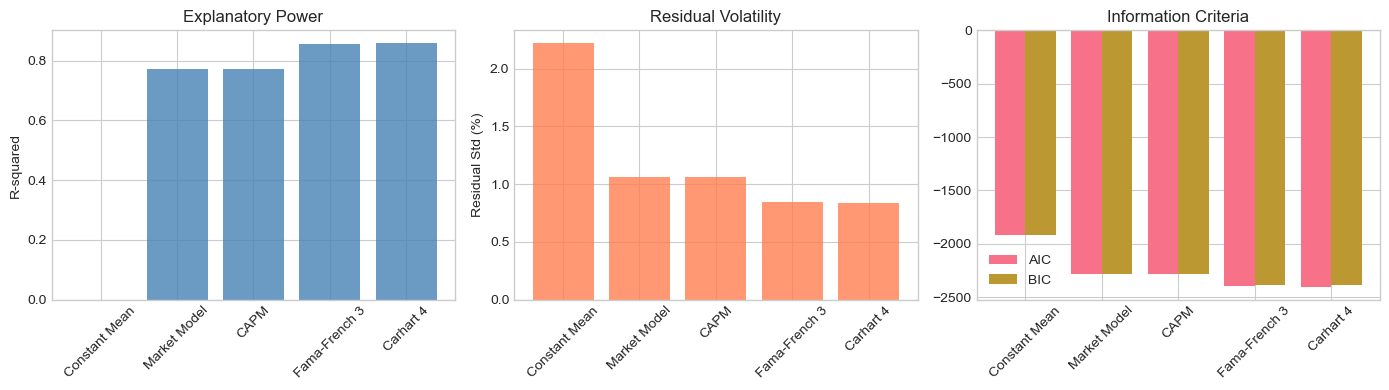

In [23]:
# Visualize
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
valid = comparison.dropna()

axes[0].bar(valid['Model'], valid['R2'], color='steelblue', alpha=0.8)
axes[0].set_ylabel('R-squared')
axes[0].set_title('Explanatory Power')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(valid['Model'], valid['Sigma']*100, color='coral', alpha=0.8)
axes[1].set_ylabel('Residual Std (%)')
axes[1].set_title('Residual Volatility')
axes[1].tick_params(axis='x', rotation=45)

x = np.arange(len(valid))
axes[2].bar(x - 0.2, valid['AIC'], 0.4, label='AIC')
axes[2].bar(x + 0.2, valid['BIC'], 0.4, label='BIC')
axes[2].set_xticks(x)
axes[2].set_xticklabels(valid['Model'], rotation=45)
axes[2].set_title('Information Criteria')
axes[2].legend()

plt.tight_layout()
plt.show()

## 10. Calculating Abnormal Returns Across Models

In [25]:
def calc_ar_all_models(event_data, models_dict):
    results = event_data[['event_time', 'stock_ret', 'market_ret']].copy()
    
    for name, model in models_dict.items():
        if model is None:
            continue
        if name == 'Constant Mean':
            expected = model.predict(len(event_data))
        elif name == 'Market Model':
            expected = model.predict(event_data['market_ret'])
        elif name == 'CAPM':
            expected = model.predict_return(event_data['market_ret'], event_data['rf'])
        elif name == 'Fama-French 3':
            expected = model.predict_return(event_data['market_ret'], event_data['rf'],
                                            event_data['SMB'], event_data['HML'])
        elif name == 'Carhart 4':
            mkt_ex = event_data['market_ret'] - event_data['rf']
            exp_ex = model.predict(mkt_ex, event_data['SMB'], event_data['HML'], event_data['MOM'])
            expected = exp_ex + event_data['rf'].values
        else:
            continue
        col = name.replace(' ', '_').replace('-', '')
        results[f'AR_{col}'] = event_data['stock_ret'].values - expected
    return results

ar_results = calc_ar_all_models(event_data, all_models)
ar_cols = [c for c in ar_results.columns if c.startswith('AR_')]

print("\nAbnormal Returns by Model (Event Window):")
display_df = ar_results[['event_time'] + ar_cols].copy()
for col in ar_cols:
    display_df[col] = display_df[col].apply(lambda x: f"{x*100:+.2f}%")
print(display_df.to_string(index=False))


Abnormal Returns by Model (Event Window):
 event_time AR_Constant_Mean AR_Market_Model AR_CAPM AR_FamaFrench_3 AR_Carhart_4
         -5           +0.58%          +0.74%  +0.75%          +0.19%       +0.15%
         -4           -1.78%          +0.12%  +0.12%          -0.73%       -0.80%
         -3           -1.53%          -0.65%  -0.65%          -0.87%       -0.76%
         -2           +3.68%          +1.16%  +1.16%          +0.75%       +0.54%
         -1           +1.09%          -0.53%  -0.53%          -0.69%       -0.86%
          0           -0.11%          -0.12%  -0.11%          -0.16%       -0.08%
          1           -0.48%          -0.55%  -0.55%          -0.24%       -0.18%
          2           +3.18%          +1.67%  +1.68%          +1.15%       +1.15%
          3           +0.18%          -0.24%  -0.24%          -0.67%       -0.96%
          4           -2.09%          -0.52%  -0.52%          -0.48%       -0.40%
          5           +2.21%          +0.24%  +0.24%   

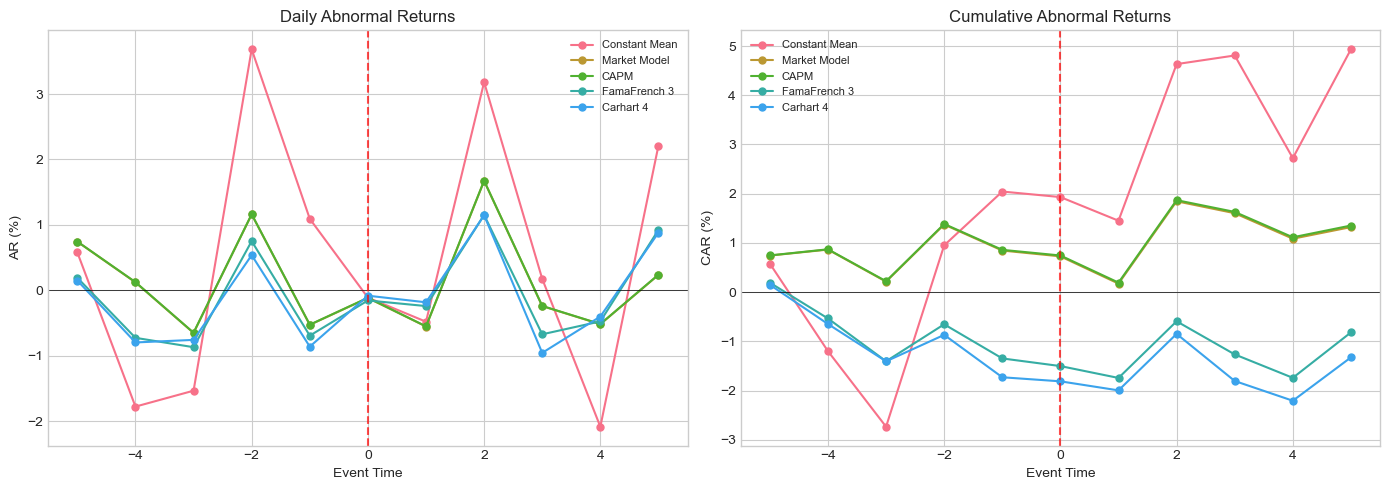

In [27]:
# Plot CARs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for col in ar_cols:
    name = col.replace('AR_', '').replace('_', ' ')
    axes[0].plot(ar_results['event_time'], ar_results[col]*100, 'o-', label=name, markersize=5)
axes[0].axhline(0, color='k', lw=0.5)
axes[0].axvline(0, color='r', ls='--', alpha=0.7)
axes[0].set_xlabel('Event Time')
axes[0].set_ylabel('AR (%)')
axes[0].set_title('Daily Abnormal Returns')
axes[0].legend(fontsize=8)

for col in ar_cols:
    name = col.replace('AR_', '').replace('_', ' ')
    car = ar_results[col].cumsum()
    axes[1].plot(ar_results['event_time'], car*100, 'o-', label=name, markersize=5)
axes[1].axhline(0, color='k', lw=0.5)
axes[1].axvline(0, color='r', ls='--', alpha=0.7)
axes[1].set_xlabel('Event Time')
axes[1].set_ylabel('CAR (%)')
axes[1].set_title('Cumulative Abnormal Returns')
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

In [29]:
# CAR Summary
windows = [(-1, 1), (0, 0), (-5, 5), (-2, 2)]
summary = []
for w_s, w_e in windows:
    mask = (ar_results['event_time'] >= w_s) & (ar_results['event_time'] <= w_e)
    row = {'Window': f'[{w_s:+d},{w_e:+d}]'}
    for col in ar_cols:
        row[col.replace('AR_', '')] = f"{ar_results.loc[mask, col].sum()*100:+.2f}%"
    summary.append(row)

print("\nCAR Summary:")
print(pd.DataFrame(summary).to_string(index=False))


CAR Summary:
 Window Constant_Mean Market_Model   CAPM FamaFrench_3 Carhart_4
[-1,+1]        +0.50%       -1.20% -1.19%       -1.09%    -1.13%
[+0,+0]        -0.11%       -0.12% -0.11%       -0.16%    -0.08%
[-5,+5]        +4.93%       +1.32% +1.35%       -0.82%    -1.33%
[-2,+2]        +7.37%       +1.63% +1.65%       +0.81%    +0.56%


## 11. Diagnostic Tests

In [31]:
def run_diagnostics(model, name):
    if not hasattr(model, 'ols_results') or model.ols_results is None:
        return
    print(f"\n{'='*50}")
    print(f"Diagnostics: {name}")
    print(f"{'='*50}")
    res = model.residuals
    
    jb_stat, jb_p = stats.jarque_bera(res)
    print(f"Jarque-Bera: stat={jb_stat:.2f}, p={jb_p:.4f}")
    
    dw = durbin_watson(res)
    print(f"Durbin-Watson: {dw:.4f}")
    
    lb = acorr_ljungbox(res, lags=[5, 10], return_df=True)
    print(f"Ljung-Box(5): Q={lb.iloc[0]['lb_stat']:.2f}, p={lb.iloc[0]['lb_pvalue']:.4f}")
    print(f"Ljung-Box(10): Q={lb.iloc[1]['lb_stat']:.2f}, p={lb.iloc[1]['lb_pvalue']:.4f}")

run_diagnostics(market_model, 'Market Model')


Diagnostics: Market Model
Jarque-Bera: stat=556.98, p=0.0000
Durbin-Watson: 1.9551
Ljung-Box(5): Q=1.42, p=0.9226
Ljung-Box(10): Q=17.39, p=0.0662


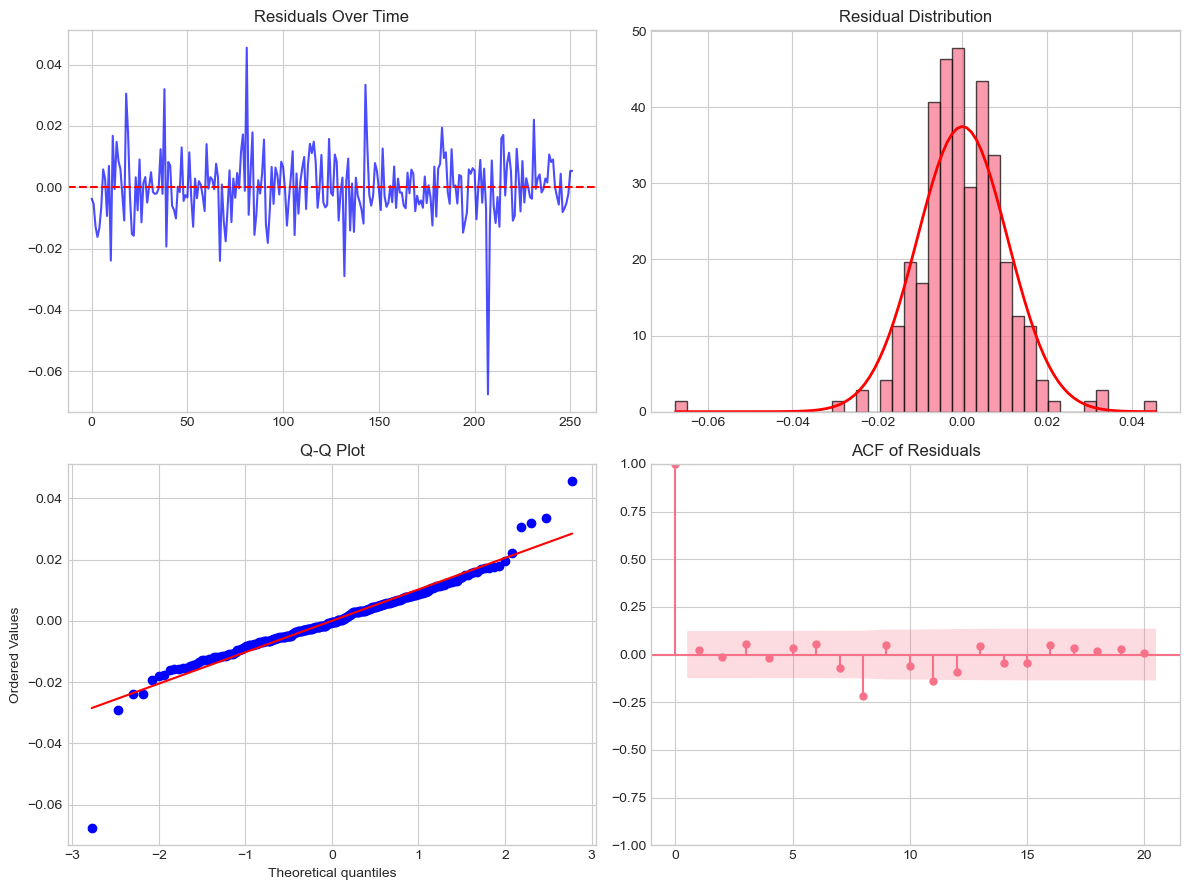

In [33]:
# Visual diagnostics
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
res = market_model.residuals

axes[0,0].plot(res, 'b-', alpha=0.7)
axes[0,0].axhline(0, color='r', ls='--')
axes[0,0].set_title('Residuals Over Time')

axes[0,1].hist(res, bins=40, density=True, alpha=0.7, edgecolor='k')
x = np.linspace(res.min(), res.max(), 100)
axes[0,1].plot(x, stats.norm.pdf(x, 0, market_model.sigma), 'r-', lw=2)
axes[0,1].set_title('Residual Distribution')

stats.probplot(res, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot')

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(res, ax=axes[1,1], lags=20, alpha=0.05)
axes[1,1].set_title('ACF of Residuals')

plt.tight_layout()
plt.show()

## 12. Estimation Window Sensitivity

In [35]:
def sensitivity_window_length(data, window_lengths, gap, pre, post):
    results = []
    for wl in window_lengths:
        est_end = -(gap + pre)
        est_start = est_end - wl
        est_data = data[(data['event_time'] >= est_start) & (data['event_time'] < est_end)]
        evt_data = data[(data['event_time'] >= -pre) & (data['event_time'] <= post)]
        if len(est_data) < wl * 0.8:
            continue
        model = MarketModel()
        model.fit(est_data['stock_ret'], est_data['market_ret'])
        ar = evt_data['stock_ret'].values - model.predict(evt_data['market_ret'])
        mask = (evt_data['event_time'] >= -1) & (evt_data['event_time'] <= 1)
        car_11 = ar[mask.values].sum()
        results.append({'Window': wl, 'Beta': model.beta, 'R2': model.r_squared, 'CAR(-1,+1)': car_11})
    return pd.DataFrame(results)

sens = sensitivity_window_length(data, [60, 90, 120, 180, 252], GAP, EVENT_WINDOW_PRE, EVENT_WINDOW_POST)
sens['CAR(-1,+1)'] = sens['CAR(-1,+1)'].apply(lambda x: f"{x*100:+.2f}%")
print("\nWindow Length Sensitivity:")
print(sens.to_string(index=False))


Window Length Sensitivity:
 Window     Beta       R2 CAR(-1,+1)
     60 1.494040 0.800374     -1.26%
     90 1.341619 0.800232     -1.20%
    120 1.355269 0.786442     -1.14%
    180 1.262944 0.784654     -1.28%
    252 1.283172 0.771081     -1.20%


## 13. Special Issues: Thin Trading & Parameter Instability

In [37]:
# Dimson beta for thin trading
def dimson_beta(stock_ret, market_ret, lags=1):
    y = np.asarray(stock_ret)
    x = np.asarray(market_ret)
    n = len(y)
    X_list = [np.ones(n - 2*lags)]
    for lag in range(-lags, lags + 1):
        X_list.append(x[lags+lag:n-lags+lag])
    X = np.column_stack(X_list)
    y_trim = y[lags:-lags]
    res = sm.OLS(y_trim, X).fit()
    return np.sum(res.params[1:]), res

dim_b, _ = dimson_beta(estimation_data['stock_ret'].values, estimation_data['market_ret'].values)
print(f"\nThin Trading Adjustment:")
print(f"  Standard Beta: {market_model.beta:.4f}")
print(f"  Dimson Beta:   {dim_b:.4f}")


Thin Trading Adjustment:
  Standard Beta: 1.2832
  Dimson Beta:   1.2335


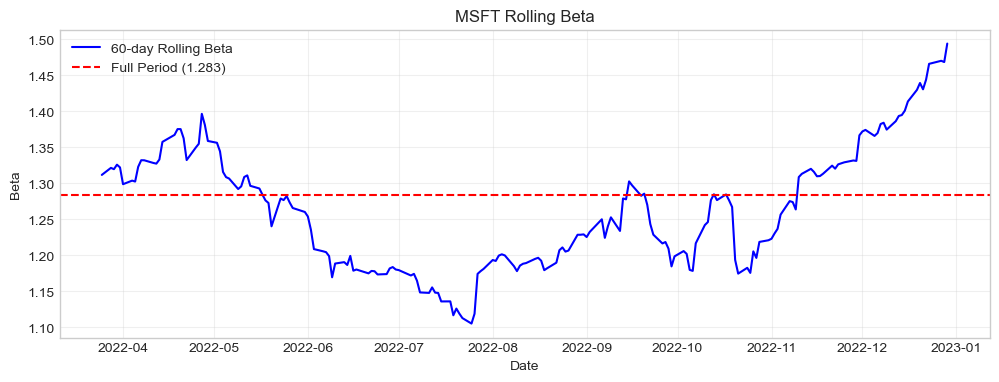

In [39]:
# Rolling beta
def rolling_beta(stock_ret, market_ret, window=60):
    betas = []
    for i in range(window, len(stock_ret)+1):
        y = stock_ret[i-window:i]
        x = market_ret[i-window:i]
        beta = np.cov(y, x)[0,1] / np.var(x, ddof=1)
        betas.append(beta)
    return np.array(betas)

rb = rolling_beta(estimation_data['stock_ret'].values, estimation_data['market_ret'].values, 60)
dates = estimation_data.index[59:]

plt.figure(figsize=(12, 4))
plt.plot(dates, rb, 'b-', label='60-day Rolling Beta')
plt.axhline(market_model.beta, color='r', ls='--', label=f'Full Period ({market_model.beta:.3f})')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.title(f'{TICKER} Rolling Beta')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 14. Model Selection Guidelines

| Model | Best For | Avoid When |
|-------|----------|------------|
| **Constant Mean** | Quick checks; diversified portfolios | Single stocks with market sensitivity |
| **Market Model** | Most firm-specific events; short horizons | Extreme market conditions |
| **CAPM** | Testing market efficiency | When alpha expected non-zero |
| **Fama-French** | Size/value sensitive stocks; IPOs | When factors unavailable |
| **Carhart** | Momentum-sensitive events | When momentum unclear |

**Practical Recommendations:**
1. Start with the market model
2. Check robustness with alternatives
3. Use factor models when appropriate
4. Run diagnostics
5. Report sensitivity analysis

## 15. Exercises

### Exercise 1: Market-Adjusted Returns
Implement a model that assumes alpha=0, beta=1. Compare with the market model.

### Exercise 2: Industry-Adjusted Returns
Use a sector ETF (e.g., XLK for tech) instead of S&P 500. When is this preferable?

### Exercise 3: Robust Standard Errors
Use heteroskedasticity-consistent (White) standard errors. Do t-statistics change?

In [41]:
# Exercise 1 Template
class MarketAdjustedModel:
    def __init__(self):
        self.name = "Market-Adjusted"
        self.sigma = None
        self.n_obs = None
        
    def fit(self, stock_ret, market_ret):
        self.n_obs = len(stock_ret)
        self.residuals = np.asarray(stock_ret) - np.asarray(market_ret)
        self.sigma = np.std(self.residuals, ddof=0)
        self.r_squared = 0  # Not comparable
        return self
    
    def predict(self, market_ret):
        return np.asarray(market_ret)

ma_model = MarketAdjustedModel()
ma_model.fit(estimation_data['stock_ret'], estimation_data['market_ret'])
print(f"Market-Adjusted Model Residual Std: {ma_model.sigma:.6f}")

Market-Adjusted Model Residual Std: 0.011442


## 16. Summary

In this session, we covered:

1. **Taxonomy of Models**: Statistical vs. economic models
2. **Implementations**: Constant mean, market model, CAPM, FF3, Carhart
3. **Comparison**: R-squared, residual variance, information criteria
4. **Diagnostics**: Normality, autocorrelation, heteroskedasticity
5. **Special Issues**: Window selection, thin trading, parameter instability

**Key Takeaway**: The market model is sufficient for most event studies. More complex models don't always improve results. Robustness checks are essential.

### Next Session
**Session 3: Measuring Abnormal Returns** - CAR, BHAR, standardized returns, wealth effects

## 17. References

- Sharpe, W. F. (1964). Capital asset prices. *Journal of Finance*.
- Fama, E. F., & French, K. R. (1993). Common risk factors. *JFE*.
- Carhart, M. M. (1997). On persistence in mutual fund performance. *JoF*.
- Dimson, E. (1979). Risk measurement when shares are subject to infrequent trading. *JFE*.
- Brown, S. J., & Warner, J. B. (1985). Using daily stock returns. *JFE*.